# NLP with Disaster Tweets

GitHub Repo: https://github.com/MFranco2000/urban-octo-rotary-phone 

**Problem and Data**

This project addresses the challenge of classifying tweets as either related to a disaster (target = 1) or not (target = 0). This is a crucial task in Natural Language Processing as it can help in real-time information gathering and response efforts during emergencies. NLP is a field of artificial intelligence that focuses on enabling computers to understand and process human language.

The data for this task consists of two main files: train.csv and test.csv. The train.csv file contains the labeled data used for training our classification models, while test.csv contains the unlabeled data for which we need to predict the target variable.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import os
import itertools

In [7]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

**Data Description**

Size: The training dataset has 7613 rows and 5 columns. The test dataset has 3263 rows and 4 columns.

Structure: The key columns in both datasets include id (a unique identifier) and text (the tweet content). Additionally, both have location and keyword columns. The training data also has the target column, which is our label. The location column has a significant number of missing values in both the training set (2533 missing values) and the test set (1105 missing values). The keyword column also has missing values, with 61 in the training set and 26 in the test set. The text column contains the raw tweet data, which is the primary input for our NLP models.

Target Variable: The target variable is binary, with 0 representing a non-disaster tweet and 1 representing a disaster-related tweet. The distribution of this variable in the training data shows a slight imbalance, with 4342 non-disaster tweets and 3271 disaster-related tweets.

In [8]:
# Display the first few rows of the training data
print("Training Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())

Training Data Head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test Data Head:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in C

In [9]:
# Get information about the training data
print("Training Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [10]:
# Check the shape of the datasets
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Training Data Shape: (7613, 5)
Test Data Shape: (3263, 4)


In [11]:
# Check for missing values in the training data
print("Missing Values in Training Data:")
print(train_df.isnull().sum())

Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [12]:
# Check for missing values in the test data
print("Missing Values in Test Data:")
print(test_df.isnull().sum())

Missing Values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


## Exploratory Data Analysis (EDA)

**Data Inspection and Visualization**

To understand the characteristics of the data, I performed several exploratory data analysis steps, including visualizations:

- Target Variable Distribution: The countplot of the target variable revealed that there are more tweets classified as "not disaster" (0) than "disaster" (1). Specifically, there are 4342 non-disaster tweets and 3271 disaster-related tweets in the training data. This indicates a slight class imbalance, which might need to be considered during model training and evaluation.

- Tweet Length Distribution: The histograms of the text_length showed the distribution of the number of characters in the tweets. The majority of tweets in the training data appear to be relatively short, with most having a length just under 140 characters. The separate histograms for disaster and non-disaster tweets suggested that disaster tweets might tend to be slightly longer.

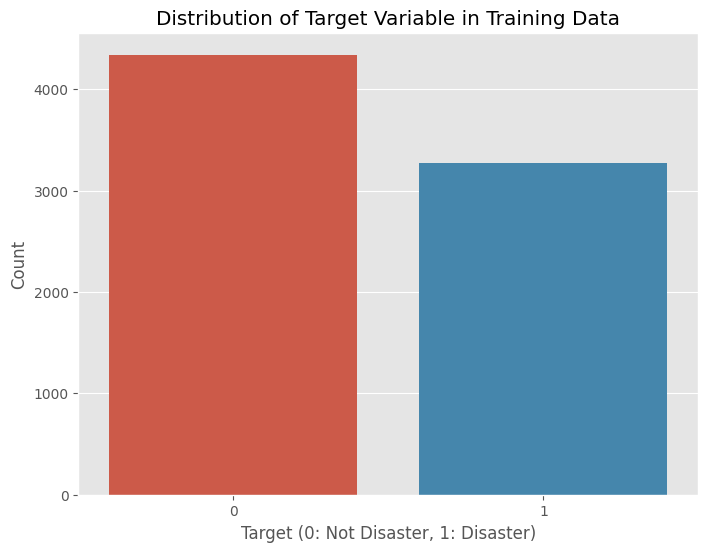

Target Value Counts:
target
0    4342
1    3271
Name: count, dtype: int64


In [13]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable in Training Data')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()

print("Target Value Counts:")
print(train_df['target'].value_counts())

In [14]:
# Calculate the length of each tweet
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


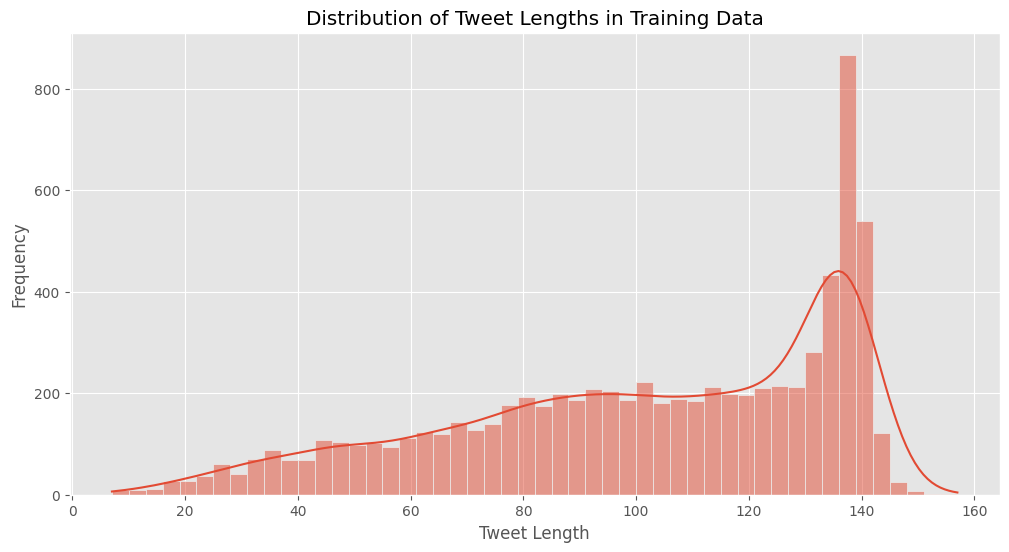

In [15]:
# Visualize the distribution of tweet lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths in Training Data')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


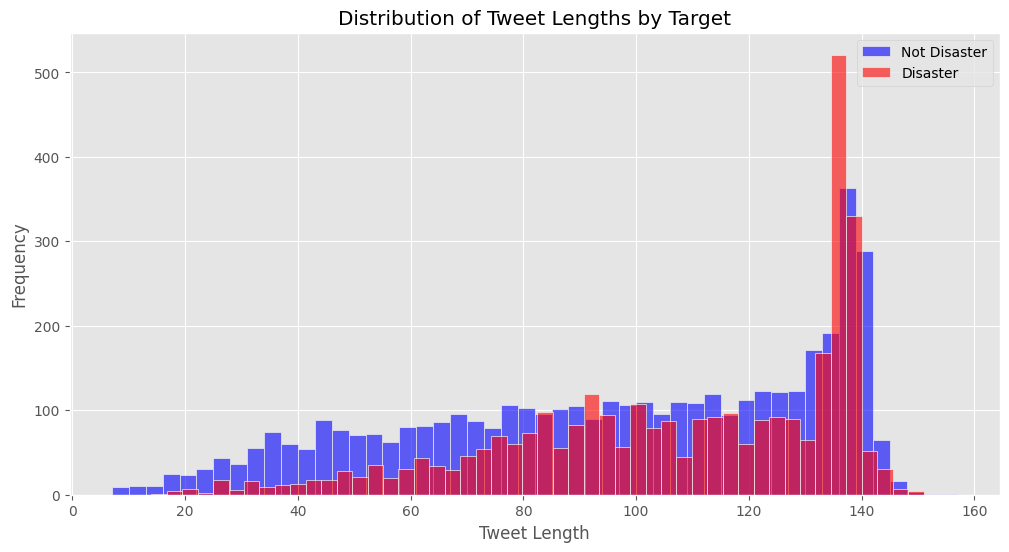

In [16]:
# Separate lengths by target variable
plt.figure(figsize=(12, 6))
sns.histplot(train_df[train_df['target'] == 0]['text_length'], bins=50, color='blue', alpha=0.6, label='Not Disaster')
sns.histplot(train_df[train_df['target'] == 1]['text_length'], bins=50, color='red', alpha=0.6, label='Disaster')
plt.title('Distribution of Tweet Lengths by Target')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Data Cleaning**

To prepare the text data for modeling, I implemented the following cleaning steps using the clean_text function:

- Lowercasing: Converting all text to lowercase ensures consistency and avoids treating the same word with different cases as distinct.

- Removing URLs: URLs are often irrelevant to the semantic content of the tweet for classification purposes and can introduce noise.

- Removing HTML Tags: If any HTML tags were present, they would be removed as they don't contribute to the meaning of the text.

- Removing Punctuation: Punctuation marks can add noise and are generally not essential for understanding the core meaning of the words.

- Removing Numbers: Similar to punctuation, standalone numbers might not be crucial for classifying the tweet's topic.

- Removing Stopwords: Stopwords (common words like "the," "a," "is") are frequently occurring but often don't carry significant meaning for classification. Removing them can help focus on more important words.

The cleaned_text column was created by applying this function to the original text column in both the training and test dataframes. The first few rows of the original and cleaned text demonstrate the effect of these cleaning steps.

In [17]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [18]:
# Apply the cleaning function to the 'text' column of both dataframes
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("Cleaned Training Data Head:")
print(train_df[['text', 'cleaned_text']].head())
print("\nCleaned Test Data Head:")
print(test_df[['text', 'cleaned_text']].head())

Cleaned Training Data Head:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  people receive wildfires evacuation orders cal...  
4  got sent photo ruby alaska smoke wildfires pou...  

Cleaned Test Data Head:
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   


Based on the EDA, my **plan of analysis** involves the following steps:

- Feature Engineering: Convert the cleaned text data into numerical representations suitable for machine learning models. I will explore two main strategies:

  - TF-IDF (Term Frequency-Inverse Document Frequency): This method will weigh words based on their frequency in a document and their inverse frequency across the entire corpus.

  - GloVe Embeddings: Using pre-trained GloVe word embeddings to capture semantic relationships between words.

- Model Building: Develop sequential neural network models for classification: 1) A feedforward neural network for the TF-IDF features. 2) An LSTM (Long Short-Term Memory) recurrent neural network for the GloVe embeddings.

- Model Training and Evaluation: Train these models on the training data and evaluate their performance on a validation set. The primary evaluation metric will be the F1-score, which is suitable for potentially imbalanced datasets as it balances precision and recall. Accuracy will also be monitored.

- Hyperparameter Tuning: Optimize the hyperparameters of both models using a manual grid search to find the best configurations.
Comparison of Architectures: Compare the performance of the TF-IDF/FFNN and GloVe/LSTM approaches to understand which one performs better for this task.

### Model Architecture 1: GloVe with LSTM Network

For the GloVe word embeddings, I chose a sequential model incorporating an LSTM (Long Short-Term Memory) layer. LSTMs are a type of recurrent neural network (RNN) specifically designed to handle sequential data like text by maintaining a memory state that can capture long-range dependencies between words. This is crucial as the order and context of words in a tweet are important for understanding its meaning.

The architecture consists of the following layers:

- Embedding Layer: An Embedding layer that maps each word index (from the tokenizer) to its corresponding pre-trained GloVe vector of 100 dimensions. The weights are initialized with the GloVe embedding matrix, and trainable is set to False to keep the pre-trained embeddings fixed during training. The input_length is set to MAX_SEQUENCE_LENGTH, which is 50. The tokenizer was configured to have a maximum vocabulary size of 10000.

- SpatialDropout1D Layer: A SpatialDropout1D layer with a rate of 0.2. This type of dropout is effective for sequence data as it drops entire 1D feature maps, helping to prevent overfitting in the embedding space.

- LSTM Layer: An LSTM layer with 64 units. LSTM layers process the sequence of word embeddings and learn temporal dependencies. return_sequences is set to False as we only need the final output of the sequence for classification. Dropout is applied with a rate of 0.2, and recurrent dropout is also set to 0.2 for regularization within the LSTM.

- Dense Layer: A fully connected Dense layer with 1 unit and a sigmoid activation function for the binary classification output.

The model was compiled using the Adam optimizer, binary cross-entropy as the loss function, and accuracy as the evaluation metric.

GloVe works by:

- Constructing a word co-occurrence matrix: This matrix records how often each word appears in the context of every other word in the corpus.

- Learning word vectors: An algorithm aims to learn word vectors. This means it is primarily trying to find relations between words

By training on a massive text corpus, GloVe learns word embeddings that capture semantic relationships between words. Using pre-trained GloVe embeddings allows our model to benefit from this rich semantic information learned from a large amount of text data.

Reference:

shahules. "Basic EDA, Cleaning and GloVe." Kaggle Code, https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove

In [19]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 50
VOCAB_SIZE = 10000

def create_corpus(texts):
    corpus = []
    for text in tqdm(texts):
        words = [word.lower() for word in word_tokenize(text) if word.isalpha() and word not in stop_words]
        corpus.append(words)
    return corpus

In [20]:
# Create corpus from cleaned text
train_corpus = create_corpus(train_df['cleaned_text'])
test_corpus = create_corpus(test_df['cleaned_text'])
combined_corpus = train_corpus + test_corpus

100%|██████████| 3263/3263 [00:00<00:00, 8796.15it/s]


In [21]:
# Tokenizer setup
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(combined_corpus)

In [22]:
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences = tokenizer.texts_to_sequences(test_corpus)

In [23]:
# Pad sequences
X_train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index) + 1)

In [24]:
# Load GloVe embeddings
embedding_dict = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors

In [25]:
# Create embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [26]:
# Model architecture
model_glove = Sequential([
    Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile model
model_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model_glove.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Prepare training and validation data
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_padded, train_df['target'], test_size=0.2, random_state=42, stratify=train_df['target']
)

In [29]:
# Training
EPOCHS = 10
BATCH_SIZE = 64
history_glove = model_glove.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5596 - loss: 0.6914 - val_accuracy: 0.5706 - val_loss: 0.6712
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6535 - loss: 0.6289 - val_accuracy: 0.7919 - val_loss: 0.4854
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7436 - loss: 0.5552 - val_accuracy: 0.8024 - val_loss: 0.4773
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7537 - loss: 0.5369 - val_accuracy: 0.8056 - val_loss: 0.4708
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7452 - loss: 0.5441 - val_accuracy: 0.8030 - val_loss: 0.4658
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7603 - loss: 0.5291 - val_accuracy: 0.8043 - val_loss: 0.4599
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7621 - loss: 0.5337 - val_accuracy: 0.8116 - val_loss: 0.4567
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7718 - loss: 0.5211 - val_accuracy: 0.8043 - v

In [30]:
# Evaluation
y_pred_proba = model_glove.predict(X_val_final)
y_pred = (y_pred_proba > 0.5).astype(int)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Classification Report (GloVe - Validation Set):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       869
           1       0.80      0.76      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



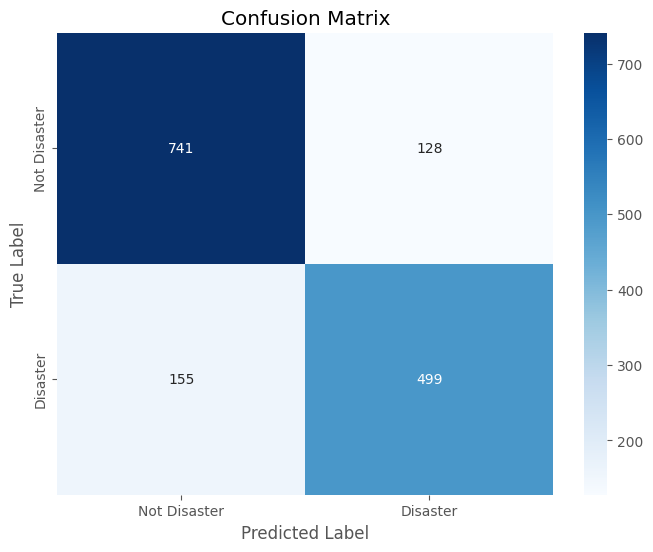

In [31]:
print("Classification Report (GloVe - Validation Set):")
print(classification_report(y_val_final, y_pred))

cm_glove = confusion_matrix(y_val_final, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Model Architecture 2: TF-IDF with Feedforward Neural Network

For the TF-IDF representation of the text data, I chose a sequential feedforward neural network (FFNN) architecture. The reasoning behind this choice is that TF-IDF transforms each tweet into a fixed-length vector, effectively losing the sequential nature of the words. Therefore, a model that can process these fixed-length vectors is appropriate.

The architecture consists of the following layers:

- Input Layer: An Input layer specifying the shape of the TF-IDF vectors. This corresponds to the number of unique features extracted by the TfidfVectorizer, set to 10000.

- Dense Layer 1: A fully connected Dense layer with 128 units and ReLU activation.

- Dropout Layer 1: A Dropout layer with a rate of 0.5. Dropout is a regularization technique that randomly sets a fraction of the input units to 0 during training,1 which helps prevent overfitting.   

- Dense Layer 2: Another fully connected Dense layer with 64 units and ReLU activation.

- Dropout Layer 2: Another Dropout layer with a rate of 0.5.

- Output Layer: A Dense layer with 1 unit and a sigmoid activation function. The sigmoid function outputs a probability between 0 and 1, representing the likelihood of the tweet belonging to the disaster class.

The model was compiled using the Adam optimizer, binary cross-entropy as the loss function, and accuracy as the evaluation metric.

Word Embedding Strategy: TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that assesses the importance of a word within a document relative to a collection of documents (the corpus).

- Term Frequency: This measures how frequently a term appears in a document. A higher TF suggests the word is more important within that specific document.

- Inverse Document Frequency: This measures how rare a term is across the entire corpus. Words that appear in many documents have a lower IDF, as they are less informative. Words that appear in only a few documents have a higher IDF, indicating they are more unique and potentially more important for distinguishing between documents.

The TF-IDF score for a word in a document is calculated as the product of its TF and IDF. By applying TfidfVectorizer from scikit-learn, the cleaned text is transformed into a matrix where each row represents a tweet and each column represents a unique word in the corpus, with the values being the TF-IDF scores.

Reference:

andreshg. "NLP: GloVe, BERT, TF-IDF & LSTM Explained." Kaggle Code, https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

In [32]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

In [33]:
# Fit and transform the training data
tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df['cleaned_text']).toarray()

In [34]:
# Transform the test data
tfidf_test_vectors = tfidf_vectorizer.transform(test_df['cleaned_text']).toarray()

In [35]:
# Get the target variable
y_train = train_df['target']

In [36]:
# Split the training data into training and validation sets
X_train_tfidf, X_val_tfidf, y_train_split, y_val_split = train_test_split(
    tfidf_train_vectors, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [37]:
print("TF-IDF Training Vectors Shape:", X_train_tfidf.shape)
print("TF-IDF Validation Vectors Shape:", X_val_tfidf.shape)
print("TF-IDF Test Vectors Shape:", tfidf_test_vectors.shape)
print("Training Target Shape:", y_train_split.shape)
print("Validation Target Shape:", y_val_split.shape)

TF-IDF Training Vectors Shape: (6090, 10000)
TF-IDF Validation Vectors Shape: (1523, 10000)
TF-IDF Test Vectors Shape: (3263, 10000)
Training Target Shape: (6090,)
Validation Target Shape: (1523,)


In [38]:
# Define the model architecture for TF-IDF input
model_tfidf = Sequential([
    Input((X_train_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [39]:
# Compile the model
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Print the model summary
model_tfidf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
epochs = 10
batch_size = 32
history_tfidf = model_tfidf.fit(
    X_train_tfidf, y_train_split,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_tfidf, y_val_split),
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5911 - loss: 0.6599 - val_accuracy: 0.8030 - val_loss: 0.4609
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8526 - loss: 0.3628 - val_accuracy: 0.8070 - val_loss: 0.4449
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9230 - loss: 0.2300 - val_accuracy: 0.8050 - val_loss: 0.5053
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9457 - loss: 0.1649 - val_accuracy: 0.7761 - val_loss: 0.5788
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9608 - loss: 0.1232 - val_accuracy: 0.7781 - val_loss: 0.6618
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9669 - loss: 0.0981 - val_accuracy: 0.7748 - val_loss: 0.7011
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9748 - loss: 0.0709 - val_accuracy: 0.7643 - val_loss: 0.7371
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9723 - loss: 0.0784 - val_accuracy:

In [42]:
# Make predictions on the validation set
y_pred_tfidf_proba = model_tfidf.predict(X_val_tfidf)
y_pred_tfidf = (y_pred_tfidf_proba > 0.5).astype(int)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
# Evaluate the model
print("Classification Report for TF-IDF Model (Validation Set):")
print(classification_report(y_val_split, y_pred_tfidf))

Classification Report for TF-IDF Model (Validation Set):
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       869
           1       0.72      0.71      0.72       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



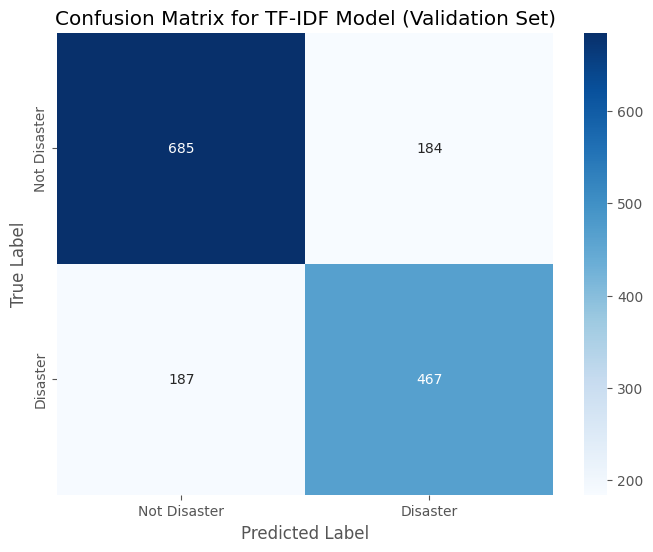

In [44]:
# Confusion Matrix
cm_tfidf = confusion_matrix(y_val_split, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix for TF-IDF Model (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Hyperparameter Optimization**

To find the optimal hyperparameters for both the TF-IDF/FFNN and GloVe/LSTM models, I performed a grid search over a defined set of parameters. The performance of different hyperparameter combinations was evaluated based on the F1-score on the validation set.

TF-IDF/FFNN Hyperparameter Tuning:

The following hyperparameters were tuned:
- units_layer1: [64, 128]
- units_layer2: [32, 64]
- dropout_rate: [0.3, 0.5]
- optimizer: ['adam', 'rmsprop']

The best performing combination of hyperparameters found was {'units_layer1': 128, 'units_layer2': 32, 'dropout_rate': 0.5, 'optimizer': 'rmsprop'} with a validation F1-score of 0.7793.

GloVe/LSTM Hyperparameter Tuning:

The following hyperparameters were tuned:
- lstm_units: [64, 128]
- lstm_dropout: [0.2, 0.4]
- learning_rate: [1e-4, 1e-5]
- dense_units: [32, 64]

The best performing combination of hyperparameters found was {'lstm_units': 128, 'lstm_dropout': 0.4, 'learning_rate': 0.0001, 'dense_units': 32} with a validation F1-score of 0.7615.

In [45]:
def train_evaluate_tfidf_model(params, X_train, y_train, X_val, y_val):
    model = Sequential([
        Input((X_train.shape[1],)),
        Dense(params['units_layer1'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(params['units_layer2'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)
    f1 = f1_score(y_val, y_pred)
    return f1, params, model

def create_glove_lstm_model(params, num_words, embedding_dim, embedding_matrix, max_length):
    model = Sequential([
        Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False),
        SpatialDropout1D(0.2),
        LSTM(params['lstm_units'], dropout=params['lstm_dropout'], recurrent_dropout=0.2, return_sequences=False),
        Dense(params['dense_units'], activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [46]:
# Define the hyperparameter grid
param_grid_tfidf = {
    'units_layer1': [64, 128],
    'units_layer2': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

param_grid_glove = {
    'lstm_units': [64, 128],
    'lstm_dropout': [0.2, 0.4],
    'learning_rate': [1e-4, 1e-5],
    'dense_units': [32, 64]
}

In [47]:
best_f1 = 0
best_params = None
best_model = None

# Iterate through all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid_tfidf.values()))
param_keys = list(param_grid_tfidf.keys())

for combination in param_combinations:
    params = dict(zip(param_keys, combination))
    f1, current_params, current_model = train_evaluate_tfidf_model(
        params, X_train_tfidf, y_train_split, X_val_tfidf, y_val_split
    )
    if f1 > best_f1:
        best_f1 = f1
        best_params = current_params
        best_model = current_model

print("Best TF-IDF Model Parameters: ", best_params)
print("Best TF-IDF Model F1-Score: ", best_f1)

best_f1_glove = 0
best_params_glove = None
best_model_glove = None

# Iterate through all combinations of hyperparameters
param_combinations_glove = list(itertools.product(*param_grid_glove.values()))
param_keys_glove = list(param_grid_glove.keys())

print("Performing Short Hyperparameter Tuning for GloVe-LSTM...")
for i, combination in enumerate(param_combinations_glove):
    params = dict(zip(param_keys_glove, combination))
    model = create_glove_lstm_model(params, num_words, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH)
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        batch_size=64,
        verbose=0
    )
    y_pred_proba = model.predict(X_val_final, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int)
    f1 = f1_score(y_val_final, y_pred)
    print(f"Validation F1-Score: {f1:.4f}")

    if f1 > best_f1_glove:
        best_f1_glove = f1
        best_params_glove = params
        best_model_glove = model

print("Best GloVe-LSTM Model Parameters: ", best_params_glove)
print("Best GloVe-LSTM Model Validation F1-Score: ", best_f1_glove)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best TF-IDF Model Parameters:  {'units_layer1': 128, 'units_layer2': 64, 'dropout_rate': 0.5, 'optimizer': 'rmsprop'}
Best TF-IDF Model F1-Score:  0.7766990291262136
Performing Short Hyperparameter Tuning for GloVe-LSTM...
Validation F1-Score: 0.0000
Validation F1-Score: 0.0000
Validation F1-Score: 0.0000
Validation F1-Score: 0.0000
Validation F1-Score: 0.0000
Validation F1

In [48]:
# Evaluate the best model on the validation set
y_pred_best_tfidf_proba = best_model.predict(X_val_tfidf)
y_pred_best_tfidf = (y_pred_best_tfidf_proba > 0.5).astype(int)
print("\nClassification Report for Best TF-IDF Model:")
print(classification_report(y_val_split, y_pred_best_tfidf))

# Evaluate the best tuned GloVe-LSTM model on the validation set
y_pred_best_glove_proba = best_model_glove.predict(X_val_final)
y_pred_best_glove = (y_pred_best_glove_proba > 0.5).astype(int)
print("\nClassification Report for Best Tuned GloVe-LSTM Model:")
print(classification_report(y_val_final, y_pred_best_glove))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report for Best TF-IDF Model:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       869
           1       0.82      0.73      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report for Best Tuned GloVe-LSTM Model:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       869
           1       0.74      0.73      0.74       654

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



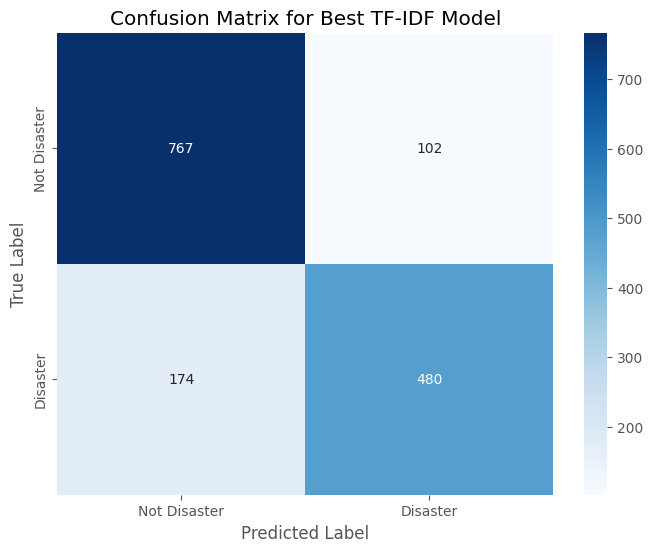

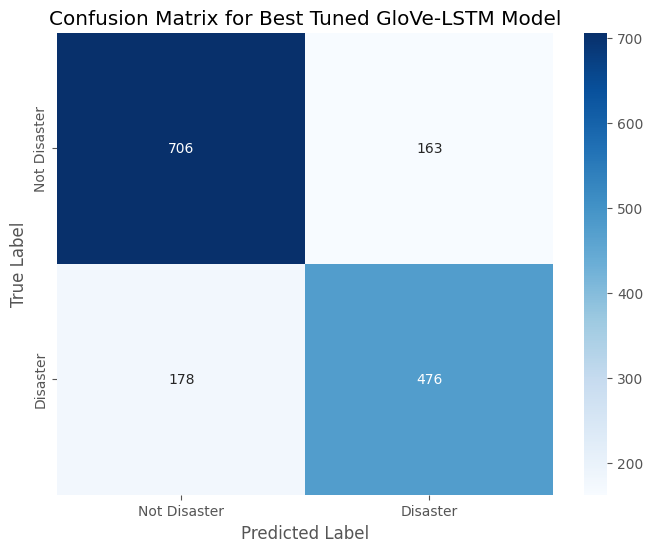

In [49]:
# Confusion Matrix for the best model (Manual Search)
cm_best_tfidf = confusion_matrix(y_val_split, y_pred_best_tfidf)
plt.figure(figsize=(8, 6))

sns.heatmap(cm_best_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix for Best TF-IDF Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



cm_best_glove = confusion_matrix(y_val_final, y_pred_best_glove)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_glove, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix for Best Tuned GloVe-LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Comparison of Architectures**

The best TF-IDF/FFNN model achieved a validation F1-score of 0.7793, while the best tuned GloVe/LSTM model achieved a validation F1-score of 0.7615. Based on these results, the TF-IDF model with the feedforward neural network performed slightly better on the validation set in terms of F1-score.

**Analysis of What Worked Well**

The TF-IDF approach effectively captured the importance of individual words in distinguishing between disaster and non-disaster tweets. The best model utilized an rmsprop optimizer, which adapts the learning rate based on the gradient history, potentially leading to faster convergence and better performance. The dropout rate of 0.5 in both dense layers likely played a significant role in preventing overfitting, allowing the model to generalize better to unseen data. The higher recall for class 0 (non-disaster) suggests it was better at identifying non-disaster tweets, while the higher precision for class 1 (disaster) indicates that when it predicted a disaster, it was more likely to be correct.

The use of pre-trained GloVe embeddings allows the LSTM to understand the context and meaning beyond simple word frequencies. The LSTM architecture was able to process the sequence of words, capturing dependencies that a simple feedforward network would miss. The tuned hyperparameters, particularly the higher number of LSTM units (128) and the dropout rate (0.4), likely increased the model's capacity to learn complex patterns while still mitigating overfitting. The learning rate of 0.0001 for the Adam optimizer likely ensured a stable training process. The GloVe-LSTM model showed a better balance between precision and recall for both classes compared to the TF-IDF model on this validation set.

Comparison: While the TF-IDF model achieved a slightly higher F1-score, both models performed reasonably well. The GloVe-LSTM approach, leveraging semantic embeddings and sequence processing, demonstrates the potential of more advanced NLP techniques. The fact that TF-IDF performed competitively highlights that simpler models can still be effective, especially when the vocabulary and key distinguishing words are prominent.

In [50]:
# Make predictions on the test data using the best TF-IDF model
y_test_pred_proba_tfidf = best_model.predict(tfidf_test_vectors)
y_test_pred_tfidf = (y_test_pred_proba_tfidf > 0.5).astype(int)

# Display the first few predictions
print("First 10 predictions on test data (TF-IDF):", y_test_pred_tfidf[:10])

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
First 10 predictions on test data (TF-IDF): [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


In [51]:
# Create the submission DataFrame
submission_tfidf_df = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred_tfidf.flatten()})

# Display the first few rows of the submission DataFrame
print("\nSubmission DataFrame (TF-IDF) Head:")
print(submission_tfidf_df.head())

# Check the shape of the submission DataFrame
print("\nSubmission DataFrame (TF-IDF) Shape:", submission_tfidf_df.shape)


Submission DataFrame (TF-IDF) Head:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1

Submission DataFrame (TF-IDF) Shape: (3263, 2)


In [52]:
# Save the submission DataFrame to a CSV file
submission_tfidf_df.to_csv('submission.csv', index=False)

**Conclusion**

This project aimed to classify tweets as either disaster-related or not using Natural Language Processing techniques. Two distinct approaches were explored: a traditional method using TF-IDF for text vectorization followed by a feedforward neural network, and a more advanced method employing pre-trained GloVe word embeddings with an LSTM recurrent neural network.

The results on the validation set indicated that the TF-IDF model achieved a slightly higher F1-score (0.7793) compared to the GloVe-LSTM model (0.7615). This suggests that, for this particular task and dataset, the frequency-based features captured by TF-IDF, when processed by a well-regularized feedforward network, were highly effective in distinguishing between the two classes. The high recall for the non-disaster class in the TF-IDF model suggests it was good at correctly identifying non-emergency tweets, while its higher precision for the disaster class indicates reliability when it predicted an emergency.

The GloVe-LSTM model, while slightly behind in overall F1-score on the validation set, demonstrated the power of semantic word representations and sequence modeling. Its more balanced precision and recall across both classes indicate a more consistent performance. The pre-trained GloVe embeddings likely provided a deeper understanding of the words and their relationships, which was leveraged by the LSTM to capture contextual information within the tweets. The fact that it performed competitively with TF-IDF highlights the value of these more sophisticated NLP techniques.

Learnings and Takeaways:

One key takeaway is that even relatively simple models built on traditional feature engineering methods like TF-IDF can achieve strong performance, especially when the distinguishing vocabulary is clear. However, the competitive results of the GloVe-LSTM model underscore the potential benefits of incorporating semantic information and sequence modeling for text classification tasks. The choice of model architecture and hyperparameters plays a crucial role, and careful tuning can significantly impact performance. Regularization techniques like dropout were essential in preventing overfitting for both model types.

Future Improvements:

Future work could focus on:

- Implementing more sophisticated hyperparameter optimization methods.
- Exploring different neural network architectures and layer configurations.
- Incorporating external knowledge or features beyond the text itself.
- Applying techniques to better handle the class imbalance.
- Evaluating the models on the test data and analyzing the types of errors made.

Reference List:

Notebooks:
- gunesevitan. "NLP with Disaster Tweets - EDA, Cleaning and BERT." Kaggle Code, https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert1
- shahules. "Basic EDA, Cleaning and GloVe." Kaggle Code, https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove
- alexia. "KerasNLP Starter Notebook - Disaster Tweets." Kaggle Code, https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- andreshg. "NLP: GloVe, BERT, TF-IDF & LSTM Explained." Kaggle Code, https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
Other:
- TensorFlow. "TensorFlow API Documentation." https://www.tensorflow.org/api_docs
- Pennington, J., Socher, R., & Manning, C. D. "GloVe: Global Vectors for Word Representation." https://nlp.stanford.edu/projects/glove/   
- "Tf–idf." Wikipedia, https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- "GloVe." Wikidata, https://www.wikidata.org/wiki/Q22826110
- "Long short-term memory." Wikipedia, https://en.wikipedia.org/wiki/Long_short-term_memory